# Predicting Dengue 
## Top score 24.6803 (BEST_benchmark_7.csv)


### Load Data and wrangle Data
> Load the data and import libraries fill na values and create new variable mean_vegetaiton_index

In [191]:
# Classic Python data science Starter pack

from pandas import DataFrame
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf # linear modeling
from sklearn.model_selection import train_test_split # Split into train test data

features = pd.read_csv('data/dengue_features_train.csv')
labels = pd.read_csv('data/dengue_labels_train.csv')


In [192]:
# Merge Train features and labels into one table
# result = pd.merge(train_features, train_labels, on=['weekofyear','year', 'city'])

# Drop Extra features
# features = features.drop(columns=[ 'station_max_temp_c','station_precip_mm', 'station_diur_temp_rng_c', 'precipitation_amt_mm'])

# Fill missing values with ffill
features.fillna(method='ffill', inplace=True)
labels.fillna(method='ffill', inplace=True)

### Add columns and split data by city
##### 0 - Iquitos
##### 1 - San Juan

In [193]:
# add column lag cases
def add_lag_cases(a, n):
    a= a.copy()
    
    # set columnm name
    name =  "lag_cases_" + str(n)
    
    #save last n values of total case
    last_n = []
    for i in range(len(a) - n,len(a)):
        last_n.append(a.iloc[i, a.columns.get_loc('total_cases')] )
        
    last_val = sum(last_n)/len(last_n)
    # shift columns  
    a[name] = a.total_cases.shift(-n)

    # add last values
    for i in range(len(a) - n,len(a)):
        a[name][i] = last_val
    return a

# add column lag cases
def add_lag_feature(a, n, fname):
    a= a.copy()
    
    # set columnm name
    name =  "lag_" + fname + str(n)
    
    #save first n values of total case
    last_n = []
    for i in range(0,n):
        last_n.append(a.iloc[i, a.columns.get_loc(fname)] )
        
    last_val = sum(last_n)/len(last_n)
    # shift columns  
    a[name] = a[fname].shift(n)

    # add last values
    for i in range(0,n):
        a[name][i] = last_val
    return a


def subset_by_city(city, df):
    return df[df.city == city]



Prepare data for final training (only features)

In [222]:
more_features = pd.read_csv('data/dengue_features_test.csv')
more_features.fillna(method='ffill', inplace=True)
final_features_by_city = [subset_by_city(c, more_features).copy().reset_index(drop=True) for c in ['iq','sj']]

final_features_by_city[0]['mean_vegetation_index'] = (final_features_by_city[0]['ndvi_se'] + final_features_by_city[0]['ndvi_sw'] + final_features_by_city[0]['ndvi_ne'] + final_features_by_city[0]['ndvi_nw']) / 4
final_features_by_city[1]['mean_vegetation_index'] = (final_features_by_city[1]['ndvi_se'] + final_features_by_city[1]['ndvi_sw'] + final_features_by_city[1]['ndvi_ne'] + final_features_by_city[1]['ndvi_nw']) / 4

final_features_by_city[0] = final_features_by_city[0].drop(columns=['ndvi_ne', 'ndvi_nw', 'ndvi_se','ndvi_sw'])
final_features_by_city[1] = final_features_by_city[1].drop(columns=['ndvi_ne', 'ndvi_nw', 'ndvi_se','ndvi_sw'])


final_features_by_city[0] = add_lag_feature(final_features_by_city[0], 12, 'weekofyear')
final_features_by_city[1] = add_lag_feature(final_features_by_city[1], 12, 'weekofyear')

final_features_by_city[0] = add_lag_feature(final_features_by_city[0], 8, 'weekofyear')
final_features_by_city[1] = add_lag_feature(final_features_by_city[1], 8, 'weekofyear')

final_features_by_city[0] = add_lag_feature(final_features_by_city[0], 4, 'weekofyear')
final_features_by_city[1] = add_lag_feature(final_features_by_city[1], 4, 'weekofyear')


final_features_by_city[0] = add_lag_feature(final_features_by_city[0], 12, 'reanalysis_specific_humidity_g_per_kg')
final_features_by_city[1] = add_lag_feature(final_features_by_city[1], 12, 'reanalysis_specific_humidity_g_per_kg')

final_features_by_city[0] = add_lag_feature(final_features_by_city[0], 8, 'reanalysis_specific_humidity_g_per_kg')
final_features_by_city[1] = add_lag_feature(final_features_by_city[1], 8, 'reanalysis_specific_humidity_g_per_kg')

final_features_by_city[0] = add_lag_feature(final_features_by_city[0], 4, 'reanalysis_specific_humidity_g_per_kg')
final_features_by_city[1] = add_lag_feature(final_features_by_city[1], 4, 'reanalysis_specific_humidity_g_per_kg')


final_features_by_city[0] = add_lag_feature(final_features_by_city[0], 12, 'station_avg_temp_c')
final_features_by_city[1] = add_lag_feature(final_features_by_city[1], 12, 'station_avg_temp_c')

final_features_by_city[0] = add_lag_feature(final_features_by_city[0], 8, 'station_avg_temp_c')
final_features_by_city[1] = add_lag_feature(final_features_by_city[1], 8, 'station_avg_temp_c')

final_features_by_city[0] = add_lag_feature(final_features_by_city[0], 4, 'station_avg_temp_c')
final_features_by_city[1] = add_lag_feature(final_features_by_city[1], 4, 'station_avg_temp_c')
final_features_by_city[0].head()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,city,year,weekofyear,week_start_date,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,mean_vegetation_index,lag_weekofyear12,lag_weekofyear8,lag_weekofyear4,lag_reanalysis_specific_humidity_g_per_kg12,lag_reanalysis_specific_humidity_g_per_kg8,lag_reanalysis_specific_humidity_g_per_kg4,lag_station_avg_temp_c12,lag_station_avg_temp_c8,lag_station_avg_temp_c4
0,iq,2010,26,2010-07-02,82.29,297.648571,299.214286,296.118571,307.9,293.7,...,0.175407,31.5,29.5,27.5,16.203929,16.232143,16.849643,27.306111,27.096667,27.07875
1,iq,2010,27,2010-07-09,25.30,298.224286,299.464286,294.831429,307.7,292.2,...,0.303885,31.5,29.5,27.5,16.203929,16.232143,16.849643,27.306111,27.096667,27.07875
2,iq,2010,28,2010-07-16,62.14,297.955714,298.964286,296.417143,306.4,292.5,...,0.260786,31.5,29.5,27.5,16.203929,16.232143,16.849643,27.306111,27.096667,27.07875
3,iq,2010,29,2010-07-23,47.80,295.715714,296.642857,293.638571,306.4,289.3,...,0.089129,31.5,29.5,27.5,16.203929,16.232143,16.849643,27.306111,27.096667,27.07875
4,iq,2010,30,2010-07-30,56.30,298.502857,300.000000,293.892857,308.1,290.5,...,0.287946,31.5,29.5,26.0,16.203929,16.232143,17.654286,27.306111,27.096667,27.44000


Prepare data for train and testing

In [221]:
# subsets data by CITY 
features_by_city = [subset_by_city(c, features).copy().reset_index(drop=True) for c in ['iq','sj']]
labels_by_city = [subset_by_city(c, labels).copy().reset_index(drop=True) for c in ['iq','sj']]


features_by_city[0] = add_lag_feature(features_by_city[0], 12, 'weekofyear')
features_by_city[1] = add_lag_feature(features_by_city[1], 12, 'weekofyear')

features_by_city[0] = add_lag_feature(features_by_city[0], 8, 'weekofyear')
features_by_city[1] = add_lag_feature(features_by_city[1], 8, 'weekofyear')

features_by_city[0] = add_lag_feature(features_by_city[0], 4, 'weekofyear')
features_by_city[1] = add_lag_feature(features_by_city[1], 4, 'weekofyear')


features_by_city[0] = add_lag_feature(features_by_city[0], 12, 'reanalysis_specific_humidity_g_per_kg')
features_by_city[1] = add_lag_feature(features_by_city[1], 12, 'reanalysis_specific_humidity_g_per_kg')

features_by_city[0] = add_lag_feature(features_by_city[0], 8, 'reanalysis_specific_humidity_g_per_kg')
features_by_city[1] = add_lag_feature(features_by_city[1], 8, 'reanalysis_specific_humidity_g_per_kg')

features_by_city[0] = add_lag_feature(features_by_city[0], 4, 'reanalysis_specific_humidity_g_per_kg')
features_by_city[1] = add_lag_feature(features_by_city[1], 4, 'reanalysis_specific_humidity_g_per_kg')


features_by_city[0] = add_lag_feature(features_by_city[0], 12, 'station_avg_temp_c')
features_by_city[1] = add_lag_feature(features_by_city[1], 12, 'station_avg_temp_c')

features_by_city[0] = add_lag_feature(features_by_city[0], 8, 'station_avg_temp_c')
features_by_city[1] = add_lag_feature(features_by_city[1], 8, 'station_avg_temp_c')

features_by_city[0] = add_lag_feature(features_by_city[0], 4, 'station_avg_temp_c')
features_by_city[1] = add_lag_feature(features_by_city[1], 4, 'station_avg_temp_c')


# add lag cases to labels
# add 4 weeks lag
labels_by_city[0] = add_lag_cases(labels_by_city[0], 4)
labels_by_city[1] = add_lag_cases(labels_by_city[1], 4)

# add 8 weeks lag
labels_by_city[0] = add_lag_cases(labels_by_city[0], 8)
labels_by_city[1] = add_lag_cases(labels_by_city[1], 8)

# add 12 weeks lag
labels_by_city[0] = add_lag_cases(labels_by_city[0], 12)
labels_by_city[1] = add_lag_cases(labels_by_city[1], 12)


# add mean vegetation index column
features_by_city[0]['mean_vegetation_index'] = (features_by_city[0]['ndvi_se'] + features_by_city[0]['ndvi_sw'] + features_by_city[0]['ndvi_ne'] + features_by_city[0]['ndvi_nw']) / 4
features_by_city[1]['mean_vegetation_index'] = (features_by_city[1]['ndvi_se'] + features_by_city[1]['ndvi_sw'] + features_by_city[1]['ndvi_ne'] + features_by_city[1]['ndvi_nw']) / 4

# Drop vegetation columns
features_by_city[0] = features_by_city[0].drop(columns=['ndvi_ne', 'ndvi_nw', 'ndvi_se','ndvi_sw'])
features_by_city[1] = features_by_city[1].drop(columns=['ndvi_ne', 'ndvi_nw', 'ndvi_se','ndvi_sw'])


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [220]:
features_by_city[0].head(20)

,weekofyear,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,...,lag_station_avg_temp_c12,lag_station_avg_temp_c8,lag_station_avg_temp_c4,lag_station_max_temp_c12,lag_station_max_temp_c8,lag_station_max_temp_c4,lag_reanalysis_dew_point_temp_k12,lag_reanalysis_dew_point_temp_k8,lag_reanalysis_dew_point_temp_k4,mean_vegetation_index
0,26,25.41,296.740000,298.450000,295.184286,307.3,293.1,43.19,92.418571,25.41,...,26.767917,26.425833,26.466667,33.466667,32.9125,32.75,293.592738,294.057500,294.740714,0.228307
1,27,60.61,296.634286,298.428571,295.358571,306.6,291.1,46.00,93.581429,60.61,...,26.767917,26.425833,26.466667,33.466667,32.9125,32.75,293.592738,294.057500,294.740714,0.256012
2,28,55.52,296.415714,297.392857,295.622857,304.5,292.6,64.77,95.848571,55.52,...,26.767917,26.425833,26.466667,33.466667,32.9125,32.75,293.592738,294.057500,294.740714,0.170504
3,29,5.60,295.357143,296.228571,292.797143,303.6,288.6,23.96,87.234286,5.60,...,26.767917,26.425833,26.466667,33.466667,32.9125,32.75,293.592738,294.057500,294.740714,0.206918
4,30,62.76,296.432857,297.635714,293.957143,307.0,291.5,31.80,88.161429,62.76,...,26.767917,26.425833,26.400000,33.466667,32.9125,32.50,293.592738,294.057500,295.184286,0.316546
5,31,16.24,297.191429,298.285714,291.725714,306.2,288.5,1.00,74.728571,16.24,...,26.767917,26.425833,26.900000,33.466667,32.9125,34.00,293.592738,294.057500,295.358571,0.220818
6,32,89.37,297.320000,298.978571,293.821429,308.8,292.1,26.68,83.275714,89.37,...,26.767917,26.425833,26.800000,33.466667,32.9125,33.00,293.592738,294.057500,295.622857,0.352582
7,33,42.08,297.627143,299.335714,293.992857,307.9,290.6,16.90,82.490000,42.08,...,26.767917,26.425833,25.766667,33.466667,32.9125,31.50,293.592738,294.057500,292.797143,0.375226
8,34,49.22,298.238571,299.571429,292.904286,310.1,291.3,5.59,74.740000,49.22,...,26.767917,26.400000,26.600000,33.466667,32.5000,33.30,293.592738,295.184286,293.957143,0.359936
9,35,53.65,299.218571,300.928571,293.472857,310.5,292.9,16.07,74.151429,53.65,...,26.767917,26.900000,25.340000,33.466667,34.0000,32.00,293.592738,295.358571,291.725714,0.322993


### Feature Selection
> Selecting top 7 features using Recursive Feature Elimination. RFE works by recursively removing attributes and building a model on attributes that remain.

In [223]:
from sklearn.feature_selection import SelectKBest, chi2, RFE, VarianceThreshold
from itertools import compress
from sklearn.ensemble import RandomForestRegressor


features_by_city[0] = features_by_city[0].drop(columns=[ 'year','city', 'week_start_date'])
features_by_city[1] = features_by_city[1].drop(columns=[ 'year','city', 'week_start_date'])

final_features_by_city[0] = final_features_by_city[0].drop(columns=[ 'year','city', 'week_start_date'])
final_features_by_city[1] = final_features_by_city[1].drop(columns=[ 'year','city', 'week_start_date'])

model = RandomForestRegressor()
rfe = RFE(model, 7)
best_feature_names = [None, None]
best_features = [None, None]
for i in [0,1]:
    best_features[i] = pd.DataFrame(rfe.fit_transform(features_by_city[i], labels_by_city[i].total_cases))
    best_feature_names[i] = list(compress(final_features_by_city[i].columns.values, rfe.get_support()))


# best_features = [pd.DataFrame(rfe.fit_transform(features_by_city[i], labels_by_city[i].total_cases)) for i in [0,1]]




In [224]:
# best_features[1]
best_feature_names[0]

['reanalysis_avg_temp_k',
 'reanalysis_max_air_temp_k',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'lag_weekofyear12',
 'lag_weekofyear4',
 'lag_reanalysis_specific_humidity_g_per_kg4']

In [225]:
best_feature_names[1]

['weekofyear',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'lag_weekofyear4',
 'lag_reanalysis_specific_humidity_g_per_kg12',
 'lag_reanalysis_specific_humidity_g_per_kg4',
 'lag_station_avg_temp_c12']

In [182]:
# These formulas are not used since we are programmatically picking features above ^^^^^^
# f0 = ['reanalysis_specific_humidity_g_per_kg', 
#                  'reanalysis_dew_point_temp_k', 
#                  'station_min_temp_c',
#                  'reanalysis_min_air_temp_k']

# f1 = ['reanalysis_specific_humidity_g_per_kg', 
#                  'reanalysis_dew_point_temp_k', 
#                  'station_avg_temp_c', 
#                  'mean_vegetation_index',
#                  'reanalysis_max_air_temp_k']

# features_by_city[0] = features_by_city[0][f0]
# features_by_city[1] = features_by_city[1][f1]


# Add best features to our training features
features_by_city[0] = best_features[0]
features_by_city[1] = best_features[1]

final_features_by_city[0] = final_features_by_city[0][best_feature_names[0]]
final_features_by_city[1] = final_features_by_city[1][best_feature_names[1]]

In [183]:
labels_by_city[0].head()

,city,year,weekofyear,total_cases,lag_cases_4,lag_cases_8,lag_cases_12
0,iq,2000,26,0,0.0,0.0,0.0
1,iq,2000,27,0,0.0,0.0,0.0
2,iq,2000,28,0,0.0,1.0,0.0
3,iq,2000,29,0,0.0,0.0,1.0
4,iq,2000,30,0,0.0,0.0,1.0


### Split Test, Train data for each city


In [184]:
# Iquitos
I_train_features, I_test_features, I_train_outcome, I_test_outcome = train_test_split(
    features_by_city[0],
    labels_by_city[0],
    test_size = 0.25,
    random_state = 11
)

In [185]:
# San Juan
sj_train_features, sj_test_features, sj_train_outcome, sj_test_outcome = train_test_split(
    features_by_city[1],
    labels_by_city[1],
    test_size = 0.25,
    random_state = 11
)

## Implementing Models

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.neighbors import KNeighborsRegressor    # regressor
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import make_pipeline  
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()# for making pipelines
scaler = MinMaxScaler()
knn_reg = KNeighborsRegressor()
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV


In [32]:
# Tracking scores from models
mae_scores = pd.DataFrame(columns=["Model", "Iquitos", "San_Juan"])
mae_scores["Model"] = ['KNN_Regressor', "RidgeCV_Regressor", "Random_Forest_Regressor", "Gradient_Boosting_Regressor", "Bagging Regressor"]
mae_scores
iq = []
sj = []



### KNN Regressor

In [229]:
# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, knn_reg)

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':range(1, 3), 
              'kneighborsregressor__n_neighbors':range(1, 4), 
              'kneighborsregressor__weights':["uniform", "distance"]}

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")

grid.fit(I_train_features, I_train_outcome.total_cases)
print(grid.score(I_test_features, I_test_outcome.total_cases))
print(grid.best_params_)
pi1 = (grid.score(I_test_features, I_test_outcome.total_cases))


grid.fit(sj_train_features, sj_train_outcome.total_cases)
print(grid.score(sj_test_features, sj_test_outcome.total_cases))
print(grid.best_params_)
ps1 = (grid.score(sj_test_features, sj_test_outcome.total_cases))


-6.40961188413
{'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance', 'polynomialfeatures__degree': 1}
-21.5844166022
{'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance', 'polynomialfeatures__degree': 1}


### RidgeCV Regressor
Improves with lag_cases_4  (1 Month Lag) for San Juan

In [228]:
ridge = RidgeCV()


# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, RidgeCV())

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':range(1, 4) }

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")

grid.fit(I_train_features, I_train_outcome.total_cases)
# grid.fit(features_by_city[0], labels_by_city[0].total_cases)
print(grid.score(I_test_features, I_test_outcome.total_cases))
print(grid.best_params_)
# a = grid.predict(final_features_by_city[0][f0]).astype(int)
pi2 = (grid.score(I_test_features, I_test_outcome.total_cases))



grid.fit(sj_train_features, sj_train_outcome.total_cases)
# grid.fit(features_by_city[1], labels_by_city[1].total_cases)
print(grid.score(sj_test_features, sj_test_outcome.lag_cases_4))
print(grid.best_params_)
# b = grid.predict(final_features_by_city[1][f1]).astype(int)
ps2 = (grid.score(sj_test_features, sj_test_outcome.total_cases))


-6.5503619702
{'polynomialfeatures__degree': 2}
-25.0797055633
{'polynomialfeatures__degree': 1}


### Random Forest Regressor

In [43]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor()

In [227]:
 

# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, random_forest)

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':[1],
             'randomforestregressor__bootstrap': [True],
             'randomforestregressor__max_depth': [10],
             'randomforestregressor__max_features': ['auto', 'sqrt'],
             'randomforestregressor__min_samples_leaf': [4],
             'randomforestregressor__min_samples_split': [10],
             'randomforestregressor__n_estimators': [ 600, 1400]}

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error", verbose=1)

grid.fit(I_train_features, I_train_outcome.total_cases)
# grid.fit(features_by_city[0], labels_by_city[0].total_cases)
print(grid.score(I_test_features, I_test_outcome.total_cases))
print(grid.best_params_)
pi3 = (grid.score(I_test_features, I_test_outcome.total_cases))
# a = grid.predict(final_features_by_city[0]).astype(int)


grid.fit(sj_train_features, sj_train_outcome.total_cases)
# grid.fit(features_by_city[1], labels_by_city[1].total_cases)
print(grid.score(sj_test_features, sj_test_outcome.total_cases))
print(grid.best_params_)
ps3 = (grid.score(sj_test_features, sj_test_outcome.total_cases))
# b = grid.predict(final_features_by_city[1]).astype(int)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   15.9s finished


-5.87060581942
{'polynomialfeatures__degree': 1, 'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 600}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   19.4s finished


-21.7457338661
{'polynomialfeatures__degree': 1, 'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 600}


### Gradient Boosting Regressor

In [231]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))

# Hyper parameter optimization already performed
#learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10
# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly,  scaler, GradientBoostingRegressor())

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':[1]
             }

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")

grid.fit(I_train_features, I_train_outcome.total_cases)
# grid.fit(features_by_city[0], labels_by_city[0].total_cases)
print(grid.score(I_test_features, I_test_outcome.total_cases))
print(grid.best_params_)
# a = grid.predict(final_features_by_city[0]).astype(int)
pi4 = (grid.score(I_test_features, I_test_outcome.total_cases))


grid.fit(sj_train_features, sj_train_outcome.total_cases)
# grid.fit(features_by_city[1], labels_by_city[1].total_cases)
print(grid.score(sj_test_features, sj_test_outcome.total_cases))
print(grid.best_params_)
# b = grid.predict(final_features_by_city[1]).astype(int)
ps4 =  (grid.score(sj_test_features, sj_test_outcome.total_cases))


-6.28353468676
{'polynomialfeatures__degree': 1}
-22.6738194538
{'polynomialfeatures__degree': 1}


pandas.core.series.Series

### Bagging Regressor 

In [230]:

from sklearn.ensemble import BaggingRegressor

# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, BaggingRegressor())

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':range(1, 4)
             }

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")

grid.fit(I_train_features, I_train_outcome.total_cases)
print(grid.score(I_test_features, I_test_outcome.total_cases))
print(grid.best_params_)
# a = grid.predict(final_features_by_city[0][f0]).astype(int)
pi5 = (grid.score(I_test_features, I_test_outcome.total_cases))


grid.fit(sj_train_features, sj_train_outcome.total_cases)
print(grid.score(sj_test_features, sj_test_outcome.total_cases))
print(grid.best_params_)
# b = grid.predict(final_features_by_city[1][f1]).astype(int)
ps5 = (grid.score(sj_test_features, sj_test_outcome.total_cases))


-6.33461538462
{'polynomialfeatures__degree': 2}
-22.8871794872
{'polynomialfeatures__degree': 2}


### Visualizing Outcomes

In [232]:
mae_scores.Iquitos = [pi1, pi2, pi3, pi4, pi5]
mae_scores.San_Juan = [ps1, ps2, ps3,  ps4, ps5]
mae_scores

,Model,Iquitos,San_Juan
0,KNN_Regressor,-6.409612,-21.584417
1,RidgeCV_Regressor,-6.550362,-26.194843
2,Random_Forest_Regressor,-5.870606,-21.745734
3,Gradient_Boosting_Regressor,-6.283535,-22.673819
4,Bagging Regressor,-6.334615,-22.887179


### Model Comparison

#### Iquitos Results

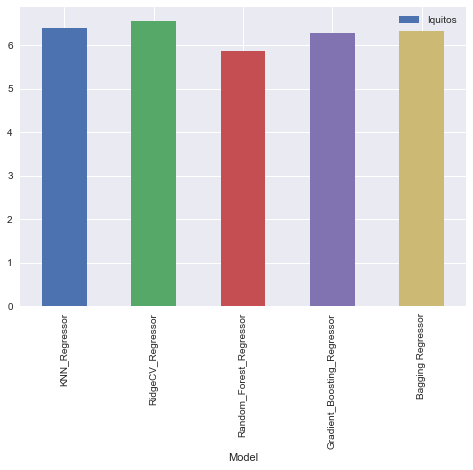

In [233]:
# Bar plot for scores of each model in increasing order of accuracy
# p = sns.barplot(x='Model', y='Iquitos', data=mae_scores)
# p.set_xticklabels(p.get_xticklabels(),rotation=30)
# p.get_figure() 
mae_scores.Iquitos = -mae_scores.Iquitos 
p = mae_scores.plot(x='Model',y= 'Iquitos', kind='bar')
p.get_figure()

#### San Juan Results 

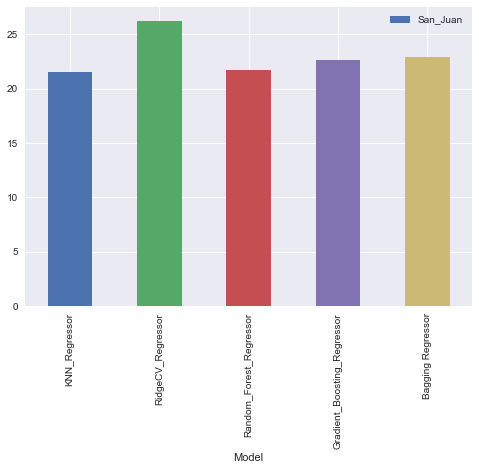

In [234]:
# Bar plot for scores of each model in increasing order of accuracy
mae_scores.San_Juan = -mae_scores.San_Juan
p = mae_scores.plot(x='Model',y= 'San_Juan', kind='bar')
p.get_figure()
# p = sns.barplot(x='Model', y='San_Juan', data=mae_scores)
# p.set_xticklabels(p.get_xticklabels(),rotation=30)
# p.get_figure() 

#### Comparing predictions to data
> Compares predicted and actual data for last run grid

In [235]:
import pylab

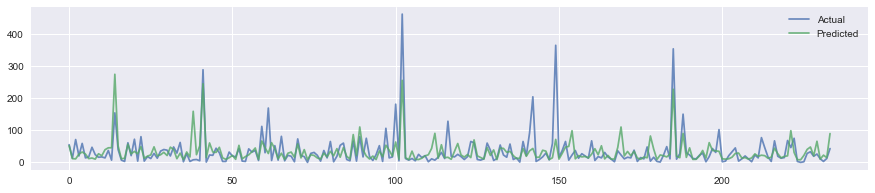

In [237]:
plt.figure(figsize=(15, 3))
sj_test_outcome.total_cases.reset_index(drop=True).plot(label="Actual", alpha = .8, kind='line')
pd.Series(grid.predict(sj_test_features)).plot(label="Predicted", alpha = .8)
plt.legend()
pylab.show()
# print(pd.Series(grid.predict(sj_test_features)))
# print(sj_test_outcome.total_cases.reset_index(drop=True))

## Submission Code

In [208]:

# submissionc code borrowed from benchmark file
submission = pd.read_csv("data/submission_format.csv")
submission.total_cases = np.concatenate([b, a])
submission 

submission.to_csv("data/benchmark_7.csv", index=False)

In [777]:
# submission